# Implementación de una aplicación Flask en AWS EC2

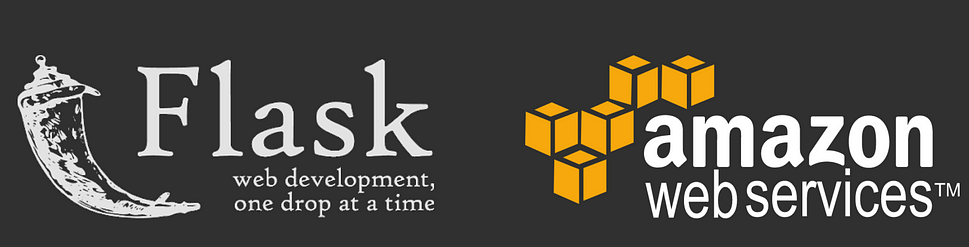

Pasos a seguir:

- Crear una instancia EC2 en AWS
- Crear aplicación Flask
- Conectarse/Transferir por SSH a EC2
- Montar el servidor Gunicorn
- Montar Nginx para aceptar y enrutar las peticiones a Gunicorn

### Paso 1: Crear una instancia EC2 en AWS

- Accedemos a AWS: https://aws.amazon.com/es y entramos con nuestra cuenta

- En el buscador indicamos EC2 para ir al recurso necesario:

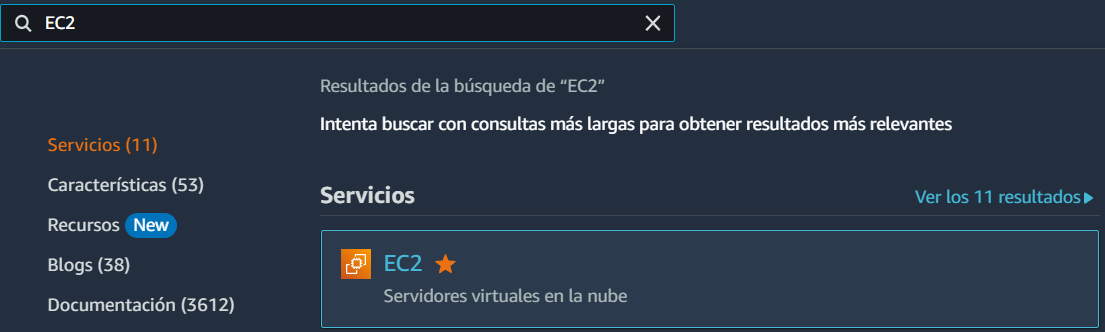

- Cremos una nueva instancia:

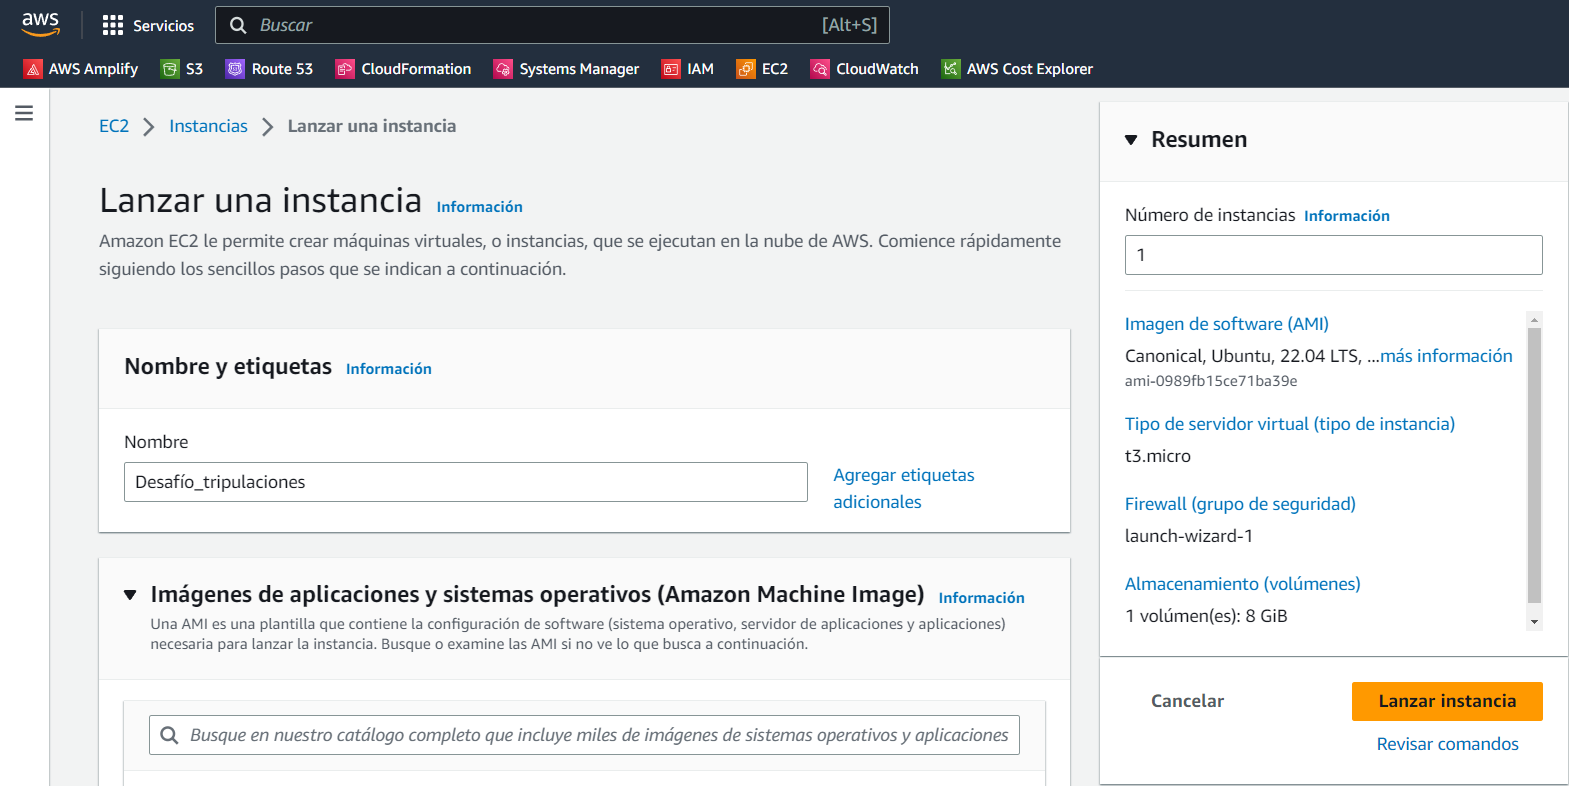

**Nombre**: Desafío_tripulaciones (Nombre que prefieras)

**SO**: Ubuntu - Nos da como opción Ubuntu Server 22.04 como apto para la capa gratuita
(Se puede elegir el que prefieras)

**Tipo de instancia**: Nos sugiere t3.micro como apta para la capa gratuita en Estocolmo

**Par de claves**: Reutilizamos unas ya creadas en formato ppk para usarla en putty

**Grupo de seguridad**: Reutilizamos uno ya creado que tiene abierto el puerto 8000

Y le damos a *Lanzar la instancia*


### Paso 2: Crear aplicación Flask

Dentro de este proyecto se puede observar el procedemiento de creación del modelo predictivo usando Series Temporales para predecir el porcentaje de agua en los embalses.

Como lo que queremos mostrar es la gráfica separando por colores entre datos real y datos que el modelo predice en vez de una consulta con x argumentos y un GET de la respuesta del modelo optamos por subir a la nube como APIrest para que lo puedan consumir nuestro compañeros de Full Stack.

Para ello creamos un entorno e importamos las librerías necesarias y ejecutamos:

In [ ]:
pip freeze > requirements.txt

El documento txt lo guardamos en la misma carpeta con el documento csv que contiene los datos:

Aplicamos el siguiente código para flask:

In [ ]:
from flask import Flask
import pandas as pd

df = pd.read_csv('tabla_pred_final.csv')

app = Flask(__name__)

@app.route('/')
def man():
    return df.to_json()

if __name__ == '__main__':
    app.run()

Igual que en el paso anterior lo guardamos con nombre app.py en la misma carpeta con el documento csv que contiene los datos y los pasamos a formato json para que los puedan consumir los compañeros de Full Stack

Comprobamos en local que funciona correctamente:

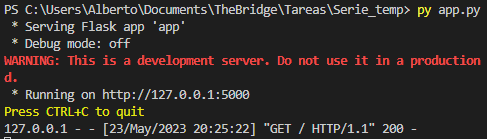


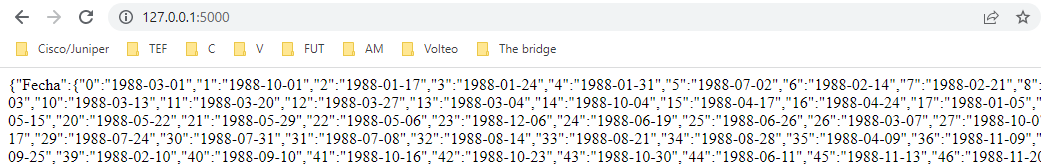

### Paso 3: Conectarse/Transferir por SSH a EC2

#### Conectarse

Para conectarse a la instancia se puede hacer desde AWS pulsando Connect:

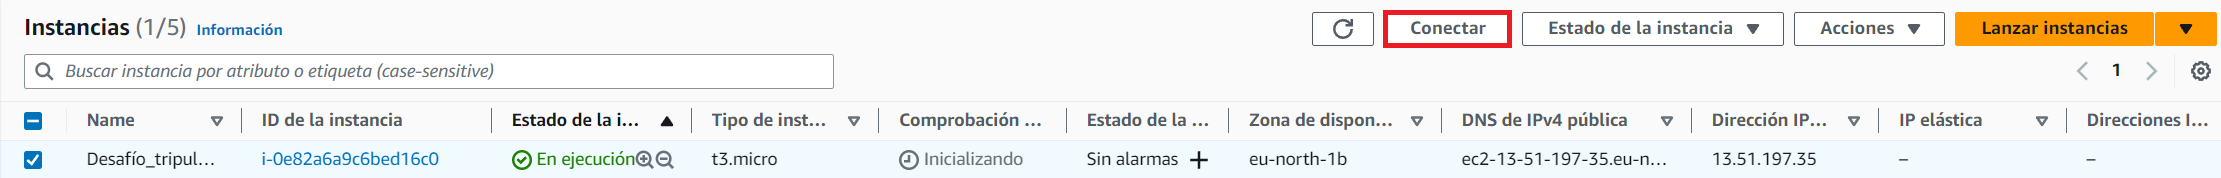

Vamos a usar putty para poder abrirla la consola varias veces:

- Especificamos como host lo que AWS y user en nuestro caso ubuntu nos indica en DNS de IPv4 pública por SSH y puerto 22

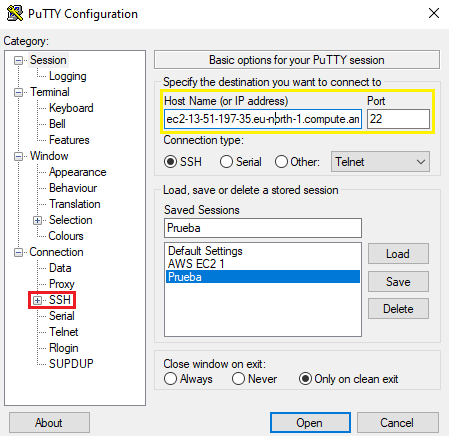

- Cargamos el archivo *ppk (No funciona pem)* en par de claves que hemos creado/reutilizado al crear la instancia

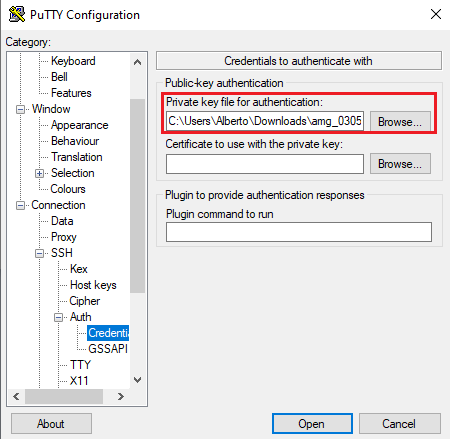

Damos a Connect Once y entramos dentro:

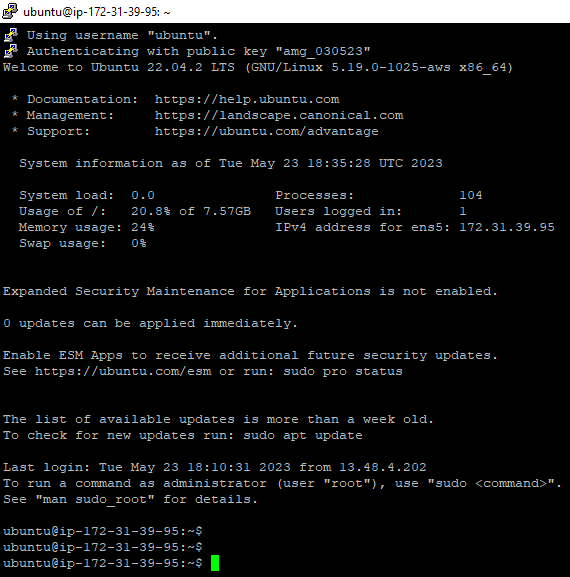

#### Transferir

Utilizamos fillezilla para conectarnos con la instancia y transferir los datos que tenemos en local

En Archivo - Gestor de sitios especificamos la conexión:

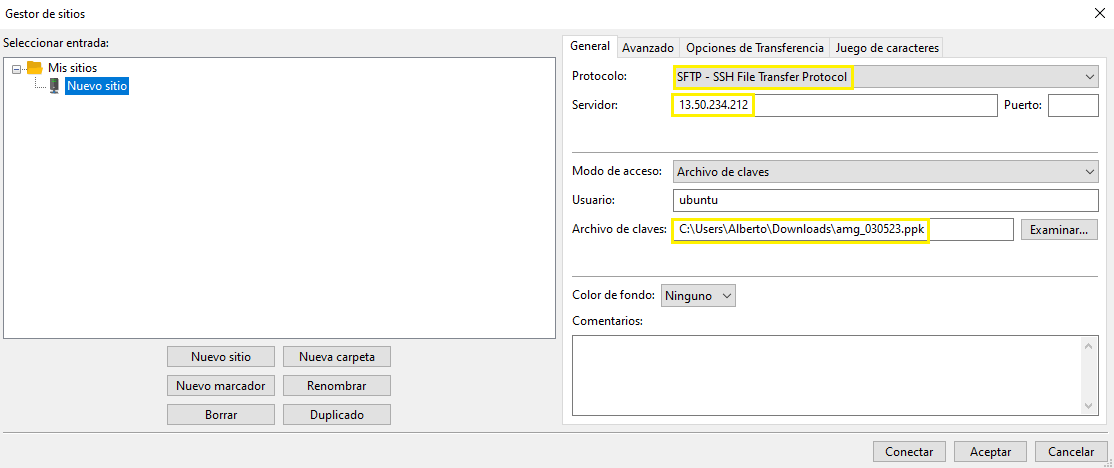



### Transferimos por SHH y comprobamos Flask en local en la instancia

Comprobación en la instancia en local del correcto funcionamiento de Flask. Para ello tenemos que instalar Python en nuestra EC2:

In [ ]:
# Actualizamos apt-get de ubuntu
sudo apt-get update

# Instalamos python para usarlo en entornos
sudo apt-get install python3-venv
"Tras este comando cuando nos pregunte si queremos escibimos Y."

# Creamos carpeta
mkdir prod

# Entramos en la carpeta
cd prod

# Creamos carpeta
mkdir endpoint

# Entramos en la carpeta
cd endpoint

#Creamos el entorno virtual
python3 -m venv venv

# Activamos el entorno para poder ejecutar comandos python
source venv/bin/activate

Ahora que tenemos el directorio final creado en la instancia, transferimos los archivos app.py, requirements.txt y tabla_pred_final.csv.

Y ejecutamos:

In [ ]:
pip install -r requirements.txt

Una vez instaladas las librerías necesarias, comprobamos que funciona Flask también:

- Ejecutamos en una terminal Flask

- Comprobamos en la otra la respuesta al puerto 5000

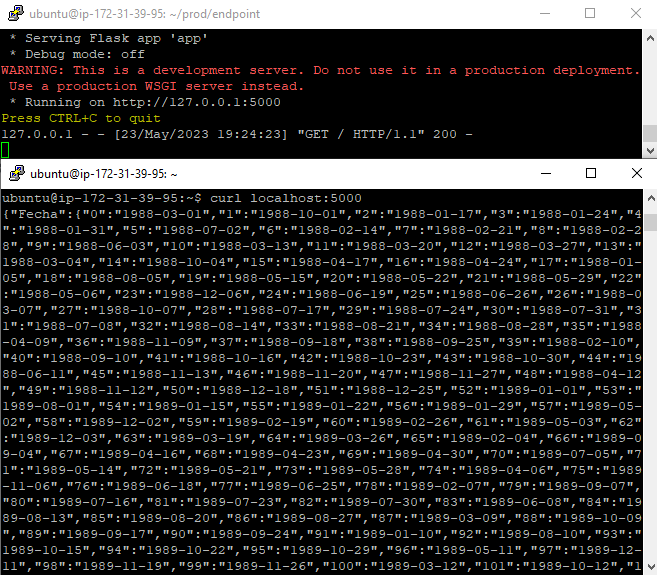

### Paso 4: Montar el servidor Gunicorn

Cuando ejecutamos Flask, en realidad está ejecutando el servidor WSGI de desarrollo de Werkzeug, que reenvía las solicitudes desde un servidor web.

Dado que Werkzeug es solo para desarrollo, tenemos que usar Gunicorn, que es un servidor WSGI listo para producción, para atender nuestra aplicación.

In [ ]:
# Instalamos Gunicorn
pip install gunicorn

# Creamos carpeta
mkdir logs

# Creamos documento e incluimos la siguiente información
sudo nano gunicorn.conf.py

In [ ]:
bind="0.0.0.0:8000"
workers=1
timeout=120
accesslog = "/home/ubuntu/prod/endpoint/logs/gunicorn.access.log"
errorlog = "/home/ubuntu/prod/endpoint/logs/gunicorn.error.log"
capture_output = True
loglevel = "info"

In [ ]:
# Ejecutamos app en Gunicorn: 
/home/ubuntu/prod/endpoint/venv/bin/gunicorn -c /home/ubuntu/prod/endpoint/gunicorn.conf.py app:app

# Creamos documento e incluimos la siguiente información
sudo nano /etc/systemd/system/prod.service

In [ ]:
[Unit]
Description=Gunicorn instance for productivization app
After=network.target
[Service]
User=ubuntu
Group=ubuntu
WorkingDirectory=/home/ubuntu/prod/endpoint
ExecStart=/home/ubuntu/prod/endpoint/venv/bin/gunicorn -c /home/ubuntu/prod/endpoint/gunicorn.conf.py app:app
Restart=always
[Install]
WantedBy=multi-user.target

In [ ]:
# Arrancamos el servicio:
sudo systemctl daemon-reload
sudo systemctl start prod.service
sudo systemctl enable prod.service

# Comprobamos el estado
sudo systemctl status prod

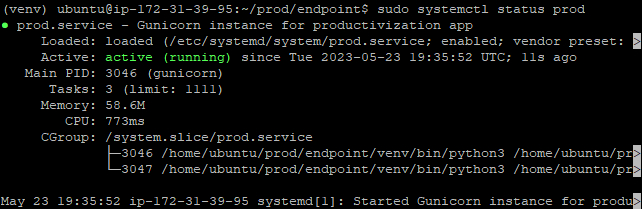

In [ ]:
# Comprobamos
curl localhost:8000

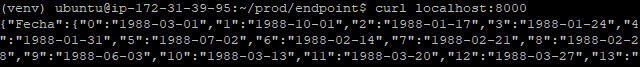

En caso error siempre revisar la carpeta de logs que hemos creado ya que Gunicorn guarda los errores y los accesos como hemos especificado en gunicorn.conf.py:

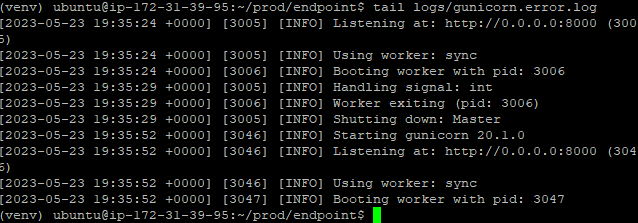

In [ ]:
tail logs/gunicorn.error.log

### Paso 5: Montar el servidor Nginx

Finalmente, configuramos Nginx como un proxy inverso para aceptar las solicitudes del usuario y enrutarlo a gunicorn.


In [ ]:
# Instalamos Nginx (en ubuntu, no en el entorno como Gunicorn)
sudo apt-get install nginx

# Creamos documento e incluimos la siguiente información
sudo nano /etc/nginx/sites-available/prod

In [ ]:
server {
 listen 80;
 server_name XXXXXXXXX; (LA IP DE LA MAQUINA)
 location / {
  proxy_pass http://127.0.0.1:8000;
 }
}

In [ ]:
# Arrancamos el servicio:
sudo systemctl start nginx
sudo systemctl enable nginx

# Comprobamos el estado
sudo systemctl status prod

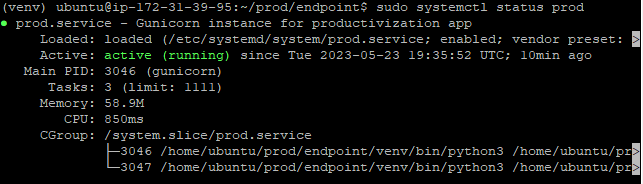

Desde el navegador podemos comprobar que esta corriendo:

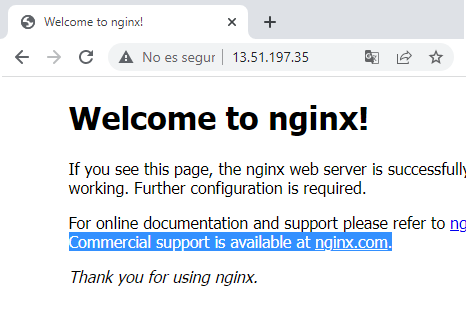

Para mirar lo que hemos subido indicamos http://13.51.197.35:8000/

In [4]:
import requests

data = requests.get('http://13.51.197.35:8000/')

print(data)
print(data.json())

<Response [200]>
{'Fecha': {'0': '1988-03-01', '1': '1988-10-01', '2': '1988-01-17', '3': '1988-01-24', '4': '1988-01-31', '5': '1988-07-02', '6': '1988-02-14', '7': '1988-02-21', '8': '1988-02-28', '9': '1988-06-03', '10': '1988-03-13', '11': '1988-03-20', '12': '1988-03-27', '13': '1988-03-04', '14': '1988-10-04', '15': '1988-04-17', '16': '1988-04-24', '17': '1988-01-05', '18': '1988-08-05', '19': '1988-05-15', '20': '1988-05-22', '21': '1988-05-29', '22': '1988-05-06', '23': '1988-12-06', '24': '1988-06-19', '25': '1988-06-26', '26': '1988-03-07', '27': '1988-10-07', '28': '1988-07-17', '29': '1988-07-24', '30': '1988-07-31', '31': '1988-07-08', '32': '1988-08-14', '33': '1988-08-21', '34': '1988-08-28', '35': '1988-04-09', '36': '1988-11-09', '37': '1988-09-18', '38': '1988-09-25', '39': '1988-02-10', '40': '1988-09-10', '41': '1988-10-16', '42': '1988-10-23', '43': '1988-10-30', '44': '1988-06-11', '45': '1988-11-13', '46': '1988-11-20', '47': '1988-11-27', '48': '1988-04-12', '4

Una vez puesto en producción para que lo puedan consumir los compañeros de Full Stack incluimos el siguiente código en app.py, instalando la librería flask_cors:

CORS se refiere a una extensión o middleware que se puede utilizar para habilitar y configurar las cabeceras CORS en una aplicación web Flask. Al habilitar CORS en Flask, puedes especificar qué métodos HTTP (GET, POST, PUT, DELETE, etc.) están permitidos:

In [ ]:
from flask import Flask
from flask_cors import CORS
import pandas as pd

df = pd.read_csv('tabla_pred_final.csv')

app = Flask(__name__)
CORS(app, origins='http://localhost:5173')

@app.route('/')
def man():
    return df.to_json()

if __name__ == '__main__':
    app.run()